# Assignment 1 (part I): Line Fitting and other "stuff"

## Problem 1
### Prove that affine transformations map lines onto lines. For this, take an arbitrary line in $R^2$ and show that an arbitrary affine transofrmation maps it onto a set of points that satisfy a line equation. Use linear algebraic equations for lines, i.e. $x^Tv=c$ where $v$ is a 2-vector (normal to the line), $c$ is a scalar ($v,c$ are line parameters), and $x$ is a 2-vector corresponding to an arbitrary point on the line. Your proof should use only linear algebraic equations. 
### HINT: for inspiration, check out the proof for homographies on slide 33, topic 4.

Solution:

Let $l=\vec{p}+t\vec{u}$ and $h=\vec{q}+t\vec{v}$ be 2 parallel lines on the 2-D plane, then $\vec{v}=k\vec{u}$ for some $k\in\mathbb{R}$.
$$f(\vec{p}+t\vec{u}) = A(\vec{p}+t\vec{u}) + \vec{b} = (A\vec{p}+\vec{b}) + t(A\vec{u})$$
$$f(\vec{q}+t\vec{v}) = A(\vec{q}+tk\vec{u}) + \vec{b} = (A\vec{q}+\vec{b}) + t(kA\vec{u})$$

Therefore, we see that after transformation, both equations are still in the form of a line, with the common direction vector $\vec{u}$

## Problem 2
### Prove that any roto-reflective transformation $R^2 \rightarrow R^2$ defined by 2x2 orthogonal matrix $R$ (s.t. $R^TR=I$) preserves (a) orthogonal lines and (b) distances between points. Your proof should use only linear algebraic equations. 

Solution:

Let $\vec{a} = [x_a, y_a]$ and $\vec{b} = [x_b, y_b]$ be 2 vectors in the $R^2$ plane s.t. they are orthogonal to each other. Then $\vec{a} \cdot \vec{b} = 0$.

After transformation, we have $R\vec{a} \cdot R\vec{b} = R(\vec{a} \cdot \vec{b}) = 0$, thus orthogonal lines are preserved.

Let $\vec{x}$ be a vector of a certain length.
$$
||R\vec{x}|| = R\vec{x} \cdot R\vec{x} = R\vec{x}^T \cdot R\vec{x} = R^T\vec{x}^T \cdot R\vec{x} = (R^T R)\vec{x}^T \cdot \vec{x}^T = ||\vec{x}||
$$
Therefore the distance is preserved.

## Problem 3 (least-squares)
### Complete implementation of function $estimate$ of class $LeastSquareLine$ below. It should update line parameters $a$ and $b$ correpsonding to line model $y=ax+b$. You can use either SVD of matrix $A$ or inverse of matrix $A^T A$, as mentioned in class. NOTE: several cells below test your code.

In [502]:
%matplotlib notebook

import numpy as np
import numpy.linalg as la
import matplotlib
import matplotlib.pyplot as plt
from skimage.measure import ransac

In [503]:
class LeastSquareLine:

    def __init__(self):
        self.a = 0.0
        self.b = 0.0
        
    def estimate(self, points2D):
        B = points2D[:,1]
        A = np.copy(points2D)
        A[:,1] = 1.0 

        # Vector B and matrix A are already defined. Change code below
        U, W, VT = la.svd(A, full_matrices=False)
        A_inv = np.matmul(np.matmul(VT.T, la.inv(np.diag(W))), U.T)
        x = np.dot(A_inv, B)
        self.a = x[0]
        self.b = x[1]
        return True
        
    def predict(self, x): return (self.a * x) + self.b
    
    def predict_y(self, x): return (self.a * x) + self.b
            
    def residuals(self, points2D):
        return points2D[:,1] - self.predict(points2D[:,0])
    
    def line_par(self):
        return self.a, self.b

## Problem 4 (RANSAC for robust line fitting, single model)

#### Working code below generates a noisy cloud of points in ${\cal R}^2$ from a given line and a group of outliers.

<IPython.core.display.Javascript object>


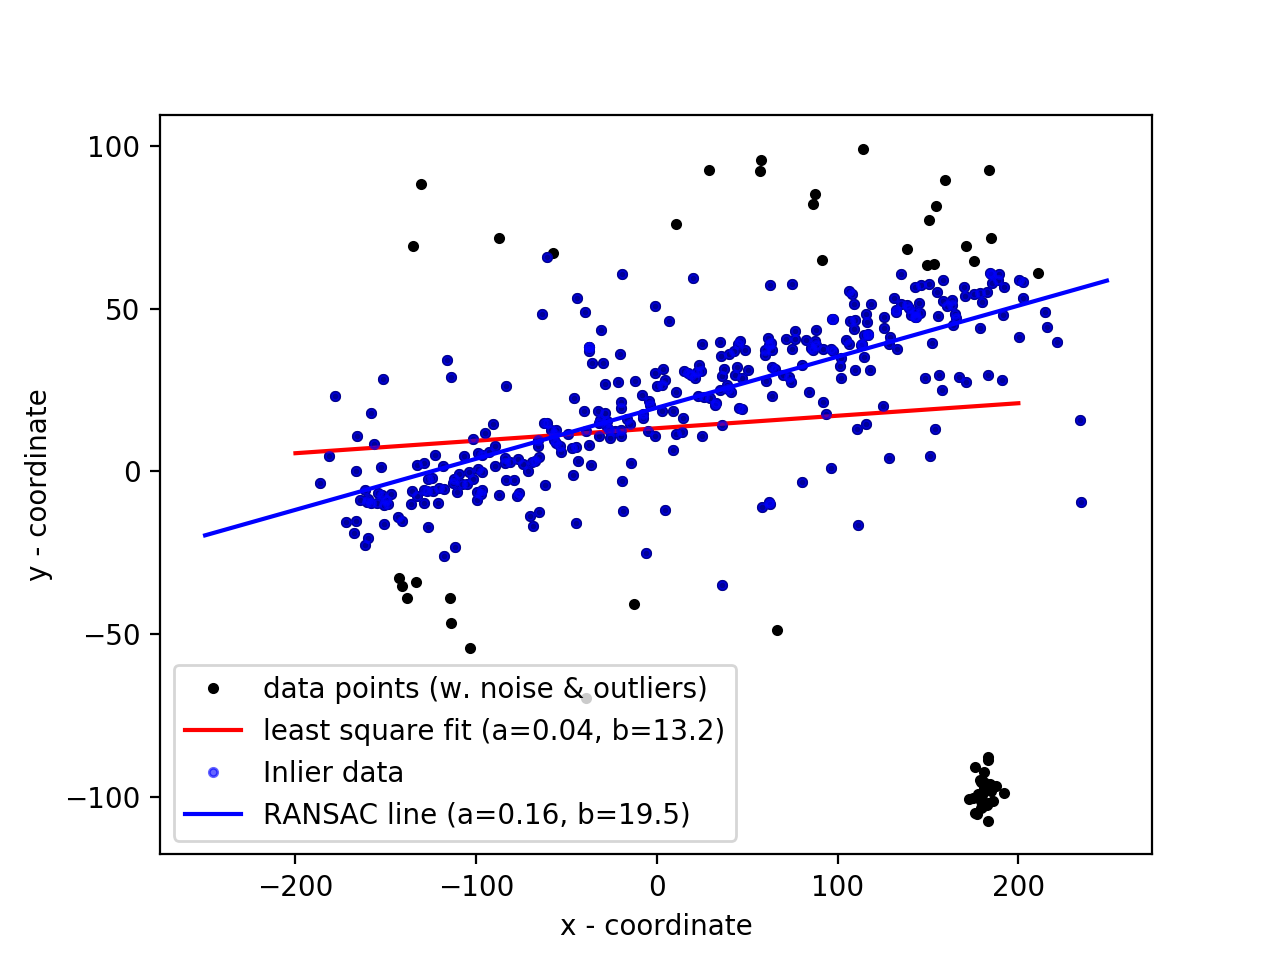

In [504]:
np.random.seed(seed=1)

# parameters for "true" line y = a*x + b
a, b = 0.2, 20.0

# x-range of points [x1,x2]
x_start, x_end = -200.0, 200.0

# generate "idealized" line points
x = np.arange(x_start,x_end)
y = a * x + b               
data = np.column_stack([x, y])    # staking data points into (Nx2) array

# add gaussian pertubations to generate "realistic" line points
noise = np.random.normal(size=data.shape) # generating Gaussian noise (variance 1) for each data point (rows in 'data')
data += 5 * noise
data[::2] += 10 * noise[::2]  # every second point adds noise with variance 5
data[::4] += 20 * noise[::4] # every fourth point adds noise with variance 20

# add outliers
faulty = np.array(30 * [(180., -100)])  # (30x2) array containing 30 rows [180,-100]  (points)
faulty += 5 * np.random.normal(size=faulty.shape)  # adding Gaussian noise to these points
data[:faulty.shape[0]] = faulty   # replacing the first 30 points in data with faulty (outliers)


fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1], '.k', label='data points (w. noise & outliers)')
ax.set_xlabel('x - coordinate')
ax.set_ylabel('y - coordinate')
ax.legend(loc='lower left')
plt.show()

#### Code below uses your implementation of class $LeastSquareLine$ for least-square line fitting for the data above. The estimated line is displayed in the cell above. Use this cell to test your code in Problem 2. Of course, your least-square line will be affected by the outliers.

In [505]:
LSline = LeastSquareLine() # uses class implemented in Problem 2
print (LSline.estimate(data))
a_ls, b_ls = LSline.line_par()

# visualizing estimated line
ends = np.array([x_start,x_end])
ax.plot(ends, LSline.predict(ends), '-r', label='least square fit (a={:4.2f}, b={:4.1f})'.format(a_ls,b_ls))
ax.legend(loc='lower left')
plt.show()

True


### (part a) Assume that a set of $N=100$ points in $2D$ includes $N_i=20$ inliers for one line and $N_o=80$ outliers. What is the least number of times one should sample a random pair of points from the set to get probability $p\geq 0.95$ that in at least one of the sampled pairs both points are inliers? Derive a general formula and compute a numerical answer for the specified numbers.

Solution:

The possibility of picking 2 outliers for a pair is: $p' = \frac{20}{100}*\frac{19}{99} = 0.0384$. First term is the first time of picking 20 outliers from 100 points, second term is picking the remaining 19 outliers from 99 points left.

The possiblity of finding at least one pair is: $p = 1-(1-p')^x$

Therefore $x = \frac{\log{(1-p)}}{\log{(1-p')}}$

The answer is $x = \frac{\log{(1-0.95)}}{\log{(1-0.0318)}} = 77$ times.

### (part b) Using the knowledge of the number of inliers/outliers in the example at the beginning of Problem 3, estimate the minimum number of sampled pairs needed to get RANSAC to "succeed" (to get at least one pair of inliers) with $p\geq 0.95$. Use your formula in part (a). Show your numbers in the cell below. Then, use your estimate as a value of parameter $max\text{_}trials$  inside function $ransac$ in the code cell below and test it.  You should also change $residual\text{_}threshold$ according to the noise level for inliers in the example. NOTE: the result is displayed in the same figure at the beginning of Problem 3.

Your estimates:
There are 400 points, and 30 of them are outliers.

So with the formula in part a), we have
$$x = \frac{\log{(1-0.95)}}{\log{(1-(\frac{370}{400}*\frac{369}{399}))}}$$
$$x = \frac{\log{(0.05)}}{\log{(0.144549)}}$$
$$x = 1.55 \approx 2$$
  
Therefore the max_trials will be 2.

In [506]:
# robustly fit line using RANSAC algorithm
model_robust, inliers = ransac(data, LeastSquareLine, min_samples=2, residual_threshold=50, max_trials=2)
a_rs, b_rs = model_robust.line_par()

# generate coordinates of estimated models
line_x = np.arange(-250, 250)
line_y_robust = model_robust.predict_y(line_x)

#fig, ax = plt.subplots()
ax.plot(data[inliers, 0], data[inliers, 1], '.b', alpha=0.6, label='Inlier data')
ax.plot(line_x, line_y_robust, '-b', label='RANSAC line (a={:4.2f}, b={:4.1f})'.format(a_rs,b_rs))
ax.legend(loc='lower left')
plt.show()

## Problem 5 (sequential RANSAC for robust multi-line fitting)

#### Generating noisy data with outliers

<IPython.core.display.Javascript object>


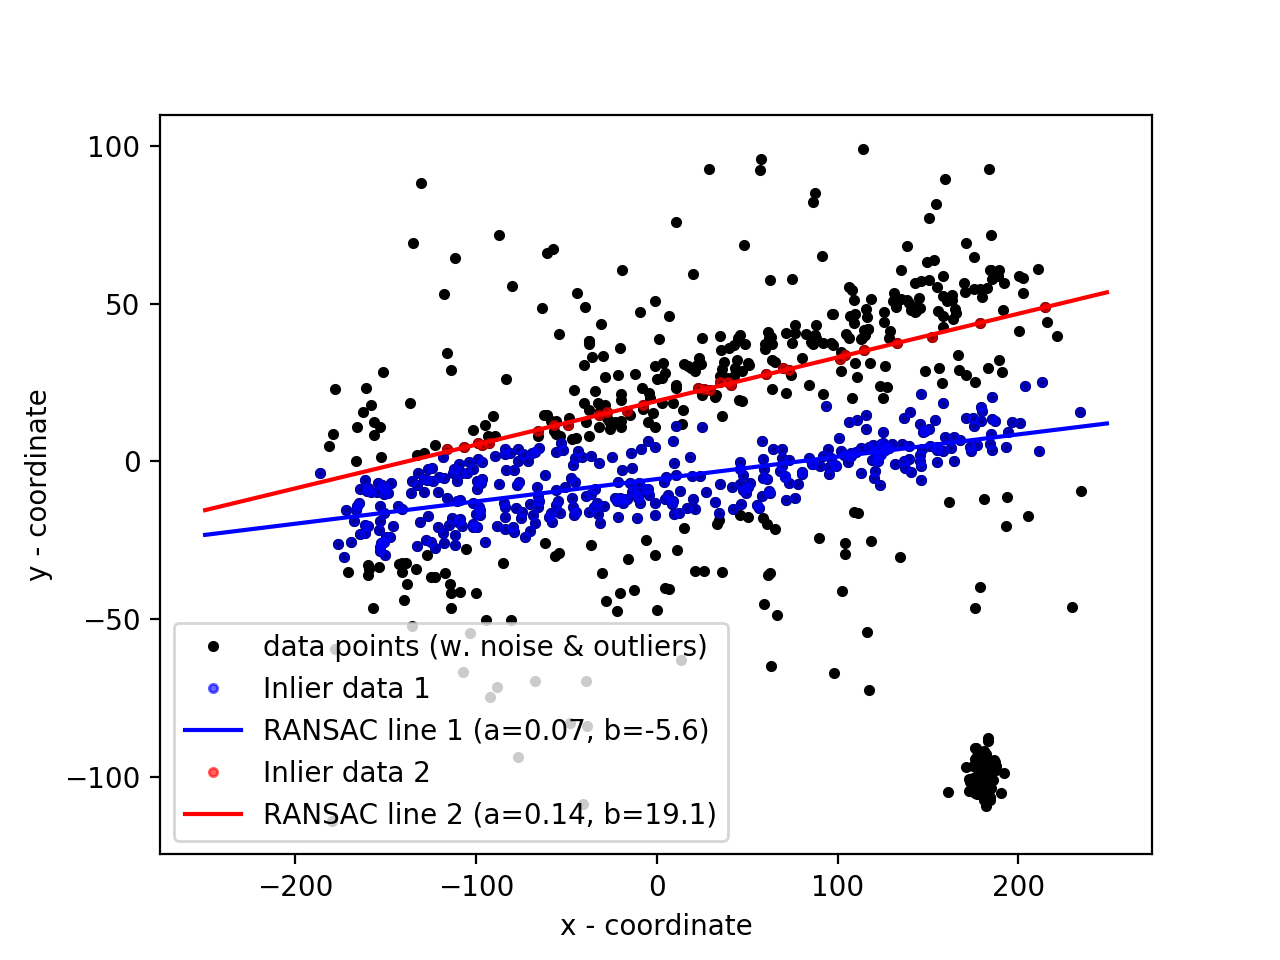

In [507]:
# parameters for "true" lines y = a*x + b
a2, b2 = 0.1, -10.0

# generate "idealized" line points
y2 = a2 * x + b2
data2 = np.column_stack([x, y2])    # staking data points into (Nx2) array

# add gaussian pertubations to generate "realistic" line data
noise = np.random.normal(size=data.shape) # generating Gaussian noise (variance 1) for each data point (rows in 'data')
data2+= 5 * noise
data2[::2] += 10 * noise[::2]  # every second point adds noise with variance 5
data2[::4] += 20 * noise[::4] # every fourth point adds noise with variance 20

# add outliers
faulty = np.array(30 * [(180., -100)])  # (30x2) array containing 30 rows [180,-100]  (points)
faulty += 5 * np.random.normal(size=faulty.shape)  # adding Gaussian noise to these points
data2[:faulty.shape[0]] = faulty   # replacing the first 30 points in data2 with faulty (outliers)

data = np.concatenate((data,data2)) # combining with previous data

fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1], '.k', label='data points (w. noise & outliers)')
ax.set_xlabel('x - coordinate')
ax.set_ylabel('y - coordinate')
ax.legend(loc='lower left')
plt.show()

### Write code below using sequential RANSAC to detect two lines in the data above. Your lines should be displayed in the figure above.

In [508]:
model_robust, inliers = ransac(data, LeastSquareLine, min_samples=2, residual_threshold=15, max_trials=50)
a_rs, b_rs = model_robust.line_par()
line_y_robust = model_robust.predict_y(line_x)

ax.plot(data[inliers, 0], data[inliers, 1], '.b', alpha=0.6, label='Inlier data 1')
ax.plot(line_x, line_y_robust, '-b', label='RANSAC line 1 (a={:4.2f}, b={:4.1f})'.format(a_rs,b_rs))
ax.legend(loc='lower left')
plt.show()

data = np.array([data[i] for i in range(data.shape[0]) if not inliers[i]])
print(data.shape)
        
model_robust2, inliers2 = ransac(data, LeastSquareLine, min_samples=2, residual_threshold=1, max_trials=50)
a_rs2, b_rs2 = model_robust2.line_par()
line_y_robust2 = model_robust2.predict_y(line_x)

ax.plot(data[inliers2, 0], data[inliers2, 1], '.r', alpha=0.6, label='Inlier data 2')
ax.plot(line_x, line_y_robust2, '-r', label='RANSAC line 2 (a={:4.2f}, b={:4.1f})'.format(a_rs2,b_rs2))
ax.legend(loc='lower left')
plt.show()

(453, 2)


## Problem 6 (multi-line fitting for Canny edges)

<IPython.core.display.Javascript object>


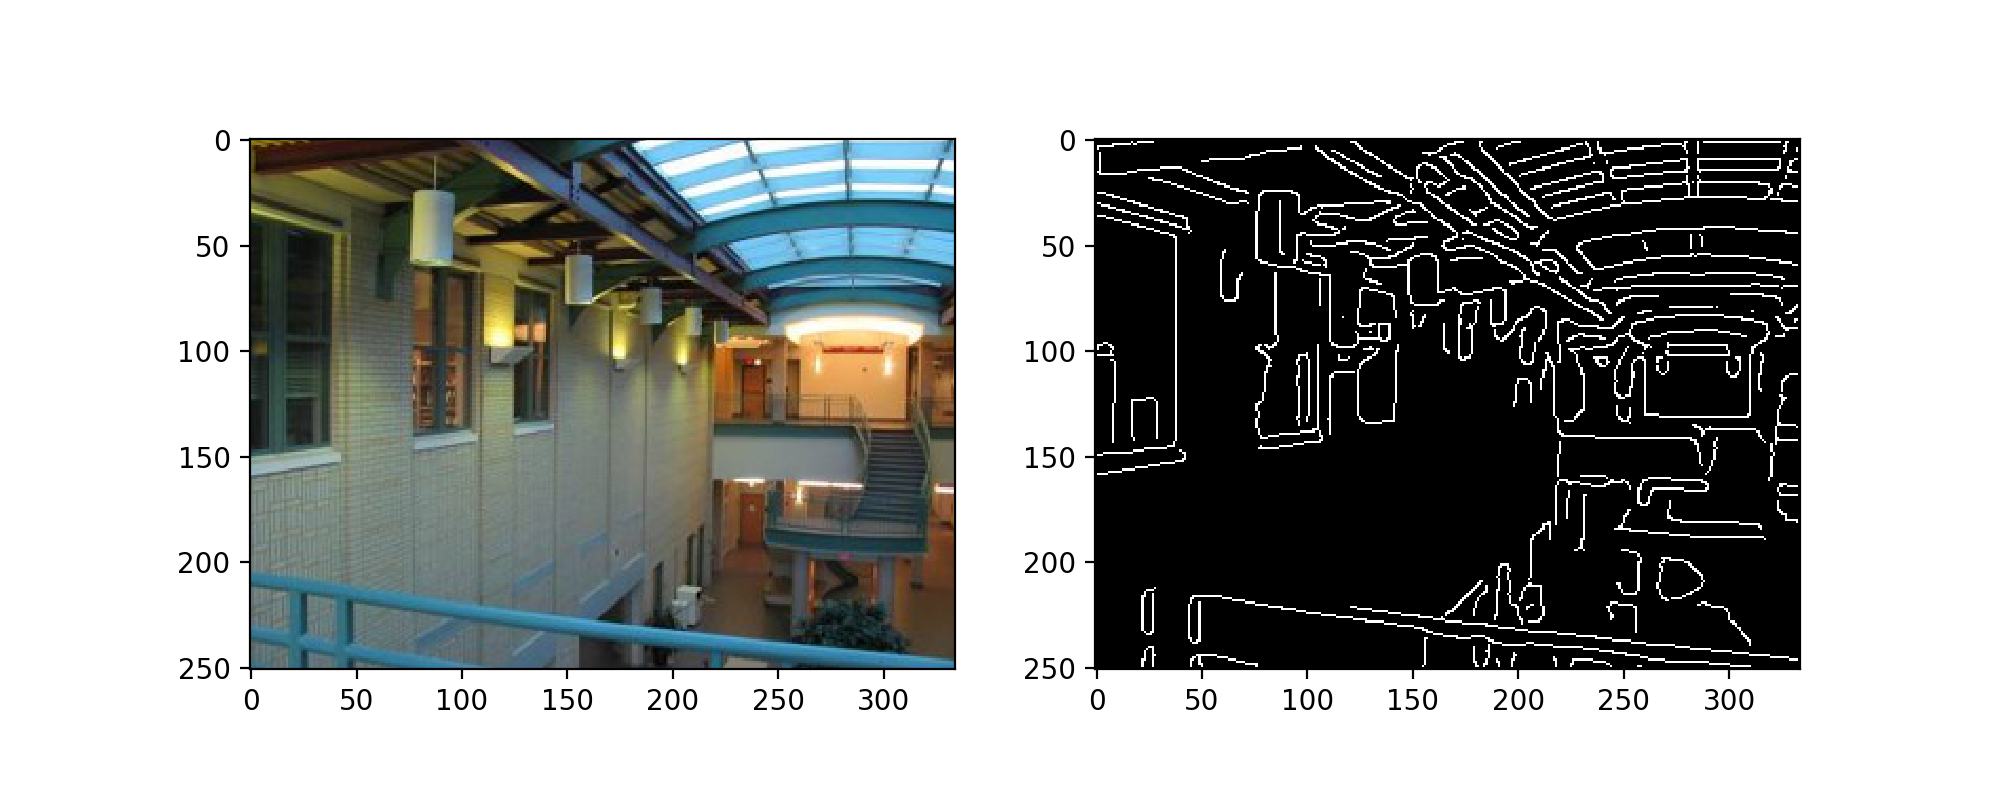

In [509]:
import matplotlib.image as image
from skimage import feature
from skimage.color import rgb2gray

im = image.imread("images/CMU_left.jpg")
imgray = rgb2gray(im)
can = feature.canny(imgray, 2.0)

plt.figure(3,figsize = (10, 4))
plt.subplot(121)
plt.imshow(im)
plt.subplot(122)
plt.imshow(can,cmap="gray")
plt.show()

## use sequestial-RANSAC to find  𝐾  lines

In [510]:
K = 5 
# NOTE 1: write your code using a function that takes K as a parameter. 
# NOTE 2: Present visual results for some value of K 
# NOTE 3: Your code should visually show detected lines in a figure 
#         over the image (either the original one or over the Canny edge mask)
# NOTE 4: You may need to play with parameters of function ransac 
#         (e.g. threshold and number of sampled models "max_trials")
#         Also, you can introduce one extra parameter for the minimum number of inliers 
#         for accepting ransac-detected lines.

# NOTE: "can" in the cell above is a binary mask with True and False values, e.g. 
print (can[20,30])
print (can[146,78])

False
True
